# Imports and functions

In [116]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score
from torcheval.metrics.functional import multiclass_auroc
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score, confusion_matrix



In [117]:
import torchvision
import engine
import engine_boosted
import engine_boosted_multi
import helper_functions

In [118]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
from collections import deque  # Import deque for early stopping
import warnings

# Suppress the specific UserWarning related to y_pred and y_true class mismatch
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

In [119]:
from sklearn.metrics import balanced_accuracy_score

# Function to calculate balanced accuracy using sklearn
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 100

In [120]:
# Function to perform one-hot encoding for DNA sequences
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    one_hot_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence]
    return np.array(one_hot_sequence)

In [121]:
kernel = {
    'ATF2': [10] ,
    'ATF3' : [10] ,
    'CEBPB' : [10] ,
    'CREB1' : [8] ,
    'CTCF' : [15] ,
    'E2F4' : [13] ,
    'EGR1' : [10] ,
    'EFL1' : [9] ,
    'ELK1' : [9] ,
    'FOS' : [8] ,
    'FOXA1' : [8] ,
    'GABPA' : [10] ,
    'JUN' : [14] ,
    'JUND' : [11] ,
    'MAFK' : [10] ,
    'MAX' : [6] ,
    'MAZ' : [8] ,
    'MXI1' : [6] ,
    'MYC' : [8] ,
    'NRF1' : [11] ,
    'RELA' : [10] ,
    'REST' : [20] ,
    'RFX5' : [14] ,
    'SP1' : [9] ,
    'SRF' : [16] ,
    'TCF7L2' : [9] ,
    'TCF12' : [7] ,
    'TEAD4' : [8] ,
    'USF1' : [10] ,
    'USF2' : [10] ,
    'YY1' : [12] ,
    'ZBTB33' : [10] ,
    'ZNF274' : [12]
}

In [122]:
tf_class = {
    'ATF2': 0,
    'ATF3': 1,
    'CEBPB': 2,
    'CREB1': 3,
    'CTCF': 4,
    'E2F4': 5,
    'EGR1': 6,
    'EFL1': 7,
    'ELK1': 8,
    'FOS': 9,
    'FOXA1': 10,
    'GABPA': 11,
    'JUN': 12,
    'JUND': 13,
    'MAFK': 14,
    'MAX': 15,
    'MAZ': 16,
    'MXI1': 17,
    'MYC': 18,
    'NRF1': 19,
    'RELA': 20,
    'REST': 21,
    'RFX5': 22,
    'SP1': 23,
    'SRF': 24,
    'TCF7L2': 25,
    'TCF12': 26,
    'TEAD4': 27,
    'USF1': 28,
    'USF2': 29,
    'YY1': 30,
    'ZBTB33': 31,
    'ZNF274': 32
}

# Set up device agnostic code

In [123]:
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [124]:
import pandas as pd

# Read the list of TFs from the file
tf_list_path = '/mnt/raid1/thalassini/home/Downloads/target_names_6.txt'
with open(tf_list_path, 'r') as file:
    tf_list = file.read().splitlines()

# Define the directory where the CSV files for each TF are located
base_directory = '/mnt/raid1/thalassini/home/filtered_fimo_regs_100/'

# Combine data for each TF and write to a single CSV file
for tf in tf_list:
    file_path = f'{base_directory}{tf.upper()}/datasets/data.csv'
    
    try:
        df = pd.read_csv(file_path)
        
        # Add a column to identify the TF
        df['TF'] = tf
        
        # Append data to the master DataFrame or create it if it doesn't exist
        if 'master_df' in locals():
            master_df = pd.concat([master_df, df], ignore_index=True)
        else:
            master_df = df
    except FileNotFoundError:
        print(f"File not found for TF: {tf}")

# Save the combined DataFrame to a new CSV file
output_csv_path = '/mnt/raid1/thalassini/home/tf_data/combined_data_len_100_chrom_regs.csv'
master_df.to_csv(output_csv_path, index=False)

print(f"Combined data saved to {output_csv_path}")


File not found for TF: RCOR1
Combined data saved to /mnt/raid1/thalassini/home/tf_data/combined_data_len_100_chrom_regs.csv


In [125]:
master_df

,chrom,region,data,class,TF
0,chr1,CTCF Binding Site,TAGAATCATCCTATGGAATGTCAGGGCTAGAAGGAGCTTGAATGAT...,1,0
1,chr12,Enhancer,ATAGCTCTCAGGTTTTGACCGCATCCCATGTGCTGGGTGCTGTGCA...,1,0
2,chr20,Enhancer,AGTTAATAGTAGCTATTAATATTACTGTGGTAAATAAGAAAGTAGT...,1,0
3,chr20,CTCF Binding Site,AGTTAATAGTAGCTATTAATATTACTGTGGTAAATAAGAAAGTAGT...,1,0
4,chrX,Open chromatin,CATTCTTGCCTCATTCCAGCAGCTTCAGAGATCAATCAGCAGAGAT...,1,0
...,...,...,...,...,...
2958643,chr19,not_regulatory,TGTGGGAAAGCATTCTCTGATTGCACAGGTTTTCGAAGACACATGA...,0,ZNF274
2958644,chr6,not_regulatory,AACTTAATAAGATACAATCAAGACAACAAACGTCTTGATTTTTATA...,0,ZNF274
2958645,chr19,not_regulatory,AAAGAGTTTTGACTTTCAGATTTTAATTTTTACCTGCAATGAGGTG...,0,ZNF274
2958646,chr19,not_regulatory,AAGAGAGAGACTCCATCTCAAAAAAAAAATTACTAACATATAATAT...,0,ZNF274


In [126]:
print("Unique values in 'TF' column before mapping:", master_df['TF'].unique())


Unique values in 'TF' column before mapping: [0 1 2 3 4 5 6 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26 25 27
 28 29 30 31 32 'ATF2' 'ATF3' 'CEBPB' 'CREB1' 'CTCF' 'E2F4' 'EGR1' 'ELF1'
 'ELK1' 'FOS' 'FOXA1' 'GABPA' 'JUN' 'JUND' 'MAFK' 'MAX' 'MAZ' 'MXI1' 'MYC'
 'NRF1' 'RELA' 'REST' 'RFX5' 'SP1' 'SRF' 'TCF12' 'TCF7L2' 'TEAD4' 'USF1'
 'USF2' 'YY1' 'ZBTB33' 'ZNF274']


In [127]:

# Apply the mapping to the 'TF' column
master_df['TF'] = master_df['TF'].map(tf_class)

# Drop rows with NaN values in the 'TF' column
master_df = master_df.dropna(subset=['TF'])

# Convert the 'TF' column to integers
master_df['TF'] = master_df['TF'].astype(int)
master_df

/tmp/ipykernel_3738262/3393081513.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['TF'] = master_df['TF'].astype(int)


,chrom,region,data,class,TF
1460896,chr1,CTCF Binding Site,TAGAATCATCCTATGGAATGTCAGGGCTAGAAGGAGCTTGAATGAT...,1,0
1460897,chr12,Enhancer,ATAGCTCTCAGGTTTTGACCGCATCCCATGTGCTGGGTGCTGTGCA...,1,0
1460898,chr20,Enhancer,AGTTAATAGTAGCTATTAATATTACTGTGGTAAATAAGAAAGTAGT...,1,0
1460899,chr20,CTCF Binding Site,AGTTAATAGTAGCTATTAATATTACTGTGGTAAATAAGAAAGTAGT...,1,0
1460900,chrX,Open chromatin,CATTCTTGCCTCATTCCAGCAGCTTCAGAGATCAATCAGCAGAGAT...,1,0
...,...,...,...,...,...
2958643,chr19,not_regulatory,TGTGGGAAAGCATTCTCTGATTGCACAGGTTTTCGAAGACACATGA...,0,32
2958644,chr6,not_regulatory,AACTTAATAAGATACAATCAAGACAACAAACGTCTTGATTTTTATA...,0,32
2958645,chr19,not_regulatory,AAAGAGTTTTGACTTTCAGATTTTAATTTTTACCTGCAATGAGGTG...,0,32
2958646,chr19,not_regulatory,AAGAGAGAGACTCCATCTCAAAAAAAAAATTACTAACATATAATAT...,0,32


# Sequence length inspection and normalization

Max length:100, Min length: 100


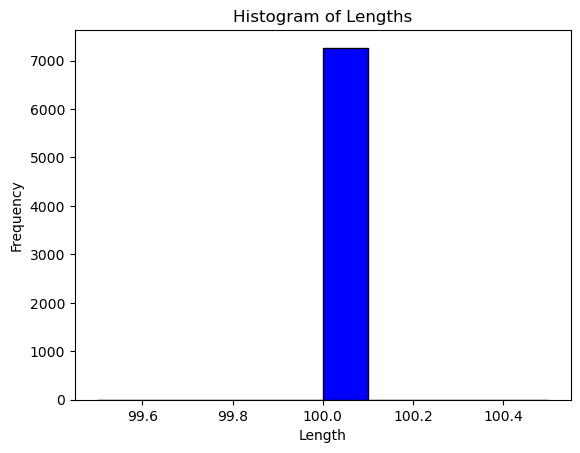

In [128]:
lengths= [len(item) for item in df['data']] 
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(lengths, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [129]:
# Find the maximum length of sequences
#min_length = min(len(seq) for seq in df['data'])
limit=200


# Pad or cut sequences to ensure they all have the same length
cut_sequences = [seq[:limit] for seq in df['data']]

# Update the DataFrame with the cut sequences
#df['data'] = cut_sequences

In [130]:
lengths= [len(item) for item in cut_sequences]
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')

Max length:100, Min length: 100


# Define X,y variables

In [131]:
X=[one_hot_encode(sequence) for sequence in cut_sequences]

In [132]:
X = torch.from_numpy(np.array(X)).type(torch.float)


In [133]:
X.shape

torch.Size([7266, 100, 4])

In [134]:
#y=np.array(df['TF'])
y=np.array(df['class'])

y[:3]

array([1, 1, 1])

In [135]:
y = torch.from_numpy(y).type(torch.float)

# Split the data in train, val and test set

In [136]:
train_loader, val_loader, test_loader = helper_functions.make_loaders(X,y)

# Construct a 1 layer CNN with Maxpooling and Dropout

In [137]:
class Conv_v1(torch.nn.Module):

    def __init__(self):
        super(Conv_v1, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=4, out_channels= 30, kernel_size= 5)
        self.conv2 = torch.nn.Conv1d(in_channels= 30, out_channels= 50, kernel_size= 5)
        self.conv3 = torch.nn.Conv1d(in_channels= 50, out_channels= 70, kernel_size= 5)
        self.activation = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size= 2)
        
        self.dropout = torch.nn.Dropout(p=0.25) 
        #in_features = 108 for 200kb, 588 for 1kb, 1188 for 2kb
        self.fc =  torch.nn.LazyLinear(out_features=2)
        #self.sigmoid = torch.nn.Sigmoid() will not be used since its intergraded in BCEWithLogitsLoss()
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x= x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        # Reshape the output of the max pooling layer before passing it to the fully connected layer
        x = x.view(x.size(0), -1)
        
        #print("Size after reshaping:", x.size())
        x=self.dropout(x)
        x = self.fc(x)
        #x = self.softmax(x)
        #x = self.sigmoid(x)
        return x


# Set up loss function and optimizer

In [138]:
torch.manual_seed(42)

# Initialize model instance
model = Conv_v1()

#loss_fn = nn.BCEWithLogitsLoss(weight=weights)
loss_fn = nn.BCEWithLogitsLoss()

# Define oprimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Define exponetntial lr with lr_scheduler
#exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

/mnt/raid1/thalassini/home/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [139]:
# Check number of classes in the model
num_classes_model = model.fc.out_features  # Adjust accordingly


In [140]:
num_classes_model

2

In [141]:
results, _ = engine_boosted.train_with_early_stopping(model=model,
                                                  train_dataloader=train_loader,
                                                  valid_dataloader=val_loader,
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=10000,
                                                  device=device)


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6931 | train_bal_acc: 0.5052 | train_mcc: 0.0292 | train_auroc: 0.5077  |  valid_loss: 0.6931 | valid_bal_acc: 0.5000 | valid_mcc: 0.0000  |  valid_auroc: 0.5257
Epoch: 2 | train_loss: 0.6929 | train_bal_acc: 0.5056 | train_mcc: 0.0293 | train_auroc: 0.5193  |  valid_loss: 0.6926 | valid_bal_acc: 0.5008 | valid_mcc: 0.0087  |  valid_auroc: 0.5939
Epoch: 3 | train_loss: 0.6925 | train_bal_acc: 0.5090 | train_mcc: 0.0358 | train_auroc: 0.5350  |  valid_loss: 0.6919 | valid_bal_acc: 0.5008 | valid_mcc: 0.0090  |  valid_auroc: 0.6273
Epoch: 4 | train_loss: 0.6921 | train_bal_acc: 0.5177 | train_mcc: 0.0751 | train_auroc: 0.5520  |  valid_loss: 0.6922 | valid_bal_acc: 0.5048 | valid_mcc: 0.0498  |  valid_auroc: 0.6659
Epoch: 5 | train_loss: 0.6916 | train_bal_acc: 0.5304 | train_mcc: 0.1058 | train_auroc: 0.5686  |  valid_loss: 0.6918 | valid_bal_acc: 0.5343 | valid_mcc: 0.1572  |  valid_auroc: 0.6902
Epoch: 6 | train_loss: 0.6913 | train_bal_acc: 0.5281 | train_mcc

Epoch: 45 | train_loss: 0.6212 | train_bal_acc: 0.7683 | train_mcc: 0.5381 | train_auroc: 0.8424  |  valid_loss: 0.6230 | valid_bal_acc: 0.7579 | valid_mcc: 0.5174  |  valid_auroc: 0.8446
Epoch: 46 | train_loss: 0.6161 | train_bal_acc: 0.7716 | train_mcc: 0.5456 | train_auroc: 0.8454  |  valid_loss: 0.6163 | valid_bal_acc: 0.7681 | valid_mcc: 0.5342  |  valid_auroc: 0.8460
Epoch: 47 | train_loss: 0.6126 | train_bal_acc: 0.7724 | train_mcc: 0.5456 | train_auroc: 0.8445  |  valid_loss: 0.6138 | valid_bal_acc: 0.7782 | valid_mcc: 0.5564  |  valid_auroc: 0.8420
Epoch: 48 | train_loss: 0.6077 | train_bal_acc: 0.7692 | train_mcc: 0.5388 | train_auroc: 0.8459  |  valid_loss: 0.6058 | valid_bal_acc: 0.7761 | valid_mcc: 0.5506  |  valid_auroc: 0.8532
Epoch: 49 | train_loss: 0.6036 | train_bal_acc: 0.7659 | train_mcc: 0.5321 | train_auroc: 0.8455  |  valid_loss: 0.6020 | valid_bal_acc: 0.7751 | valid_mcc: 0.5507  |  valid_auroc: 0.8554
Epoch: 50 | train_loss: 0.5987 | train_bal_acc: 0.7710 | tra

Epoch: 89 | train_loss: 0.4766 | train_bal_acc: 0.7879 | train_mcc: 0.5754 | train_auroc: 0.8632  |  valid_loss: 0.4607 | valid_bal_acc: 0.7994 | valid_mcc: 0.5976  |  valid_auroc: 0.8767
Epoch: 90 | train_loss: 0.4716 | train_bal_acc: 0.7951 | train_mcc: 0.5894 | train_auroc: 0.8680  |  valid_loss: 0.4666 | valid_bal_acc: 0.7974 | valid_mcc: 0.5984  |  valid_auroc: 0.8659
Epoch: 91 | train_loss: 0.4714 | train_bal_acc: 0.7908 | train_mcc: 0.5810 | train_auroc: 0.8642  |  valid_loss: 0.4607 | valid_bal_acc: 0.7951 | valid_mcc: 0.5947  |  valid_auroc: 0.8756
Epoch: 92 | train_loss: 0.4681 | train_bal_acc: 0.7919 | train_mcc: 0.5837 | train_auroc: 0.8674  |  valid_loss: 0.4816 | valid_bal_acc: 0.7741 | valid_mcc: 0.5513  |  valid_auroc: 0.8583
Epoch: 93 | train_loss: 0.4684 | train_bal_acc: 0.7947 | train_mcc: 0.5884 | train_auroc: 0.8664  |  valid_loss: 0.4659 | valid_bal_acc: 0.7722 | valid_mcc: 0.5468  |  valid_auroc: 0.8694
Epoch: 94 | train_loss: 0.4624 | train_bal_acc: 0.7958 | tra

Epoch: 133 | train_loss: 0.4251 | train_bal_acc: 0.8088 | train_mcc: 0.6175 | train_auroc: 0.8877  |  valid_loss: 0.4186 | valid_bal_acc: 0.8001 | valid_mcc: 0.6013  |  valid_auroc: 0.8924
Epoch: 134 | train_loss: 0.4195 | train_bal_acc: 0.8176 | train_mcc: 0.6351 | train_auroc: 0.8899  |  valid_loss: 0.4318 | valid_bal_acc: 0.7971 | valid_mcc: 0.5905  |  valid_auroc: 0.8805
Epoch: 135 | train_loss: 0.4230 | train_bal_acc: 0.8082 | train_mcc: 0.6174 | train_auroc: 0.8873  |  valid_loss: 0.3952 | valid_bal_acc: 0.8294 | valid_mcc: 0.6608  |  valid_auroc: 0.9027
Epoch: 136 | train_loss: 0.4221 | train_bal_acc: 0.8115 | train_mcc: 0.6230 | train_auroc: 0.8888  |  valid_loss: 0.4007 | valid_bal_acc: 0.8177 | valid_mcc: 0.6485  |  valid_auroc: 0.9053
Epoch: 137 | train_loss: 0.4205 | train_bal_acc: 0.8150 | train_mcc: 0.6313 | train_auroc: 0.8904  |  valid_loss: 0.4302 | valid_bal_acc: 0.8052 | valid_mcc: 0.6144  |  valid_auroc: 0.8902
Epoch: 138 | train_loss: 0.4200 | train_bal_acc: 0.8126

Epoch: 177 | train_loss: 0.3918 | train_bal_acc: 0.8275 | train_mcc: 0.6547 | train_auroc: 0.9033  |  valid_loss: 0.3869 | valid_bal_acc: 0.8491 | valid_mcc: 0.7003  |  valid_auroc: 0.9112
Epoch: 178 | train_loss: 0.3909 | train_bal_acc: 0.8288 | train_mcc: 0.6568 | train_auroc: 0.9062  |  valid_loss: 0.4031 | valid_bal_acc: 0.8276 | valid_mcc: 0.6570  |  valid_auroc: 0.8987
Epoch: 179 | train_loss: 0.3923 | train_bal_acc: 0.8307 | train_mcc: 0.6624 | train_auroc: 0.9047  |  valid_loss: 0.3762 | valid_bal_acc: 0.8250 | valid_mcc: 0.6690  |  valid_auroc: 0.9151
Epoch: 180 | train_loss: 0.3895 | train_bal_acc: 0.8331 | train_mcc: 0.6660 | train_auroc: 0.9054  |  valid_loss: 0.3735 | valid_bal_acc: 0.8512 | valid_mcc: 0.7037  |  valid_auroc: 0.9118
Epoch: 181 | train_loss: 0.3883 | train_bal_acc: 0.8318 | train_mcc: 0.6641 | train_auroc: 0.9067  |  valid_loss: 0.3816 | valid_bal_acc: 0.8360 | valid_mcc: 0.6742  |  valid_auroc: 0.9169
Epoch: 182 | train_loss: 0.3893 | train_bal_acc: 0.8342

Epoch: 221 | train_loss: 0.3677 | train_bal_acc: 0.8457 | train_mcc: 0.6922 | train_auroc: 0.9173  |  valid_loss: 0.3469 | valid_bal_acc: 0.8585 | valid_mcc: 0.7217  |  valid_auroc: 0.9306
Epoch: 222 | train_loss: 0.3697 | train_bal_acc: 0.8412 | train_mcc: 0.6830 | train_auroc: 0.9154  |  valid_loss: 0.3452 | valid_bal_acc: 0.8582 | valid_mcc: 0.7218  |  valid_auroc: 0.9316
Epoch: 223 | train_loss: 0.3657 | train_bal_acc: 0.8441 | train_mcc: 0.6877 | train_auroc: 0.9184  |  valid_loss: 0.3454 | valid_bal_acc: 0.8616 | valid_mcc: 0.7232  |  valid_auroc: 0.9286
Epoch: 224 | train_loss: 0.3699 | train_bal_acc: 0.8417 | train_mcc: 0.6842 | train_auroc: 0.9158  |  valid_loss: 0.3851 | valid_bal_acc: 0.8366 | valid_mcc: 0.6814  |  valid_auroc: 0.9147
Epoch: 225 | train_loss: 0.3671 | train_bal_acc: 0.8421 | train_mcc: 0.6853 | train_auroc: 0.9169  |  valid_loss: 0.3369 | valid_bal_acc: 0.8633 | valid_mcc: 0.7219  |  valid_auroc: 0.9326
Epoch: 226 | train_loss: 0.3666 | train_bal_acc: 0.8403

Epoch: 265 | train_loss: 0.3475 | train_bal_acc: 0.8519 | train_mcc: 0.7047 | train_auroc: 0.9262  |  valid_loss: 0.3516 | valid_bal_acc: 0.8696 | valid_mcc: 0.7382  |  valid_auroc: 0.9246
Epoch: 266 | train_loss: 0.3490 | train_bal_acc: 0.8550 | train_mcc: 0.7103 | train_auroc: 0.9257  |  valid_loss: 0.3138 | valid_bal_acc: 0.8799 | valid_mcc: 0.7609  |  valid_auroc: 0.9393
Epoch: 267 | train_loss: 0.3498 | train_bal_acc: 0.8483 | train_mcc: 0.6965 | train_auroc: 0.9264  |  valid_loss: 0.3166 | valid_bal_acc: 0.8847 | valid_mcc: 0.7695  |  valid_auroc: 0.9392
Epoch: 268 | train_loss: 0.3452 | train_bal_acc: 0.8565 | train_mcc: 0.7131 | train_auroc: 0.9268  |  valid_loss: 0.3288 | valid_bal_acc: 0.8804 | valid_mcc: 0.7544  |  valid_auroc: 0.9350
Epoch: 269 | train_loss: 0.3429 | train_bal_acc: 0.8544 | train_mcc: 0.7090 | train_auroc: 0.9279  |  valid_loss: 0.3430 | valid_bal_acc: 0.8502 | valid_mcc: 0.6985  |  valid_auroc: 0.9244
Epoch: 270 | train_loss: 0.3447 | train_bal_acc: 0.8558

Epoch: 309 | train_loss: 0.3298 | train_bal_acc: 0.8648 | train_mcc: 0.7296 | train_auroc: 0.9345  |  valid_loss: 0.3302 | valid_bal_acc: 0.8674 | valid_mcc: 0.7360  |  valid_auroc: 0.9333
Epoch: 310 | train_loss: 0.3272 | train_bal_acc: 0.8643 | train_mcc: 0.7302 | train_auroc: 0.9360  |  valid_loss: 0.3221 | valid_bal_acc: 0.8827 | valid_mcc: 0.7686  |  valid_auroc: 0.9317
Epoch: 311 | train_loss: 0.3297 | train_bal_acc: 0.8619 | train_mcc: 0.7234 | train_auroc: 0.9343  |  valid_loss: 0.3157 | valid_bal_acc: 0.8826 | valid_mcc: 0.7683  |  valid_auroc: 0.9373
Epoch: 312 | train_loss: 0.3325 | train_bal_acc: 0.8608 | train_mcc: 0.7214 | train_auroc: 0.9326  |  valid_loss: 0.3162 | valid_bal_acc: 0.8865 | valid_mcc: 0.7675  |  valid_auroc: 0.9425
Epoch: 313 | train_loss: 0.3262 | train_bal_acc: 0.8630 | train_mcc: 0.7278 | train_auroc: 0.9353  |  valid_loss: 0.3039 | valid_bal_acc: 0.8832 | valid_mcc: 0.7676  |  valid_auroc: 0.9450
Epoch: 314 | train_loss: 0.3310 | train_bal_acc: 0.8628

Epoch: 353 | train_loss: 0.3156 | train_bal_acc: 0.8708 | train_mcc: 0.7399 | train_auroc: 0.9414  |  valid_loss: 0.3075 | valid_bal_acc: 0.8822 | valid_mcc: 0.7615  |  valid_auroc: 0.9510
Epoch: 354 | train_loss: 0.3137 | train_bal_acc: 0.8710 | train_mcc: 0.7412 | train_auroc: 0.9412  |  valid_loss: 0.2875 | valid_bal_acc: 0.8940 | valid_mcc: 0.7880  |  valid_auroc: 0.9495
Epoch: 355 | train_loss: 0.3153 | train_bal_acc: 0.8691 | train_mcc: 0.7379 | train_auroc: 0.9402  |  valid_loss: 0.3326 | valid_bal_acc: 0.8795 | valid_mcc: 0.7511  |  valid_auroc: 0.9269
Epoch: 356 | train_loss: 0.3123 | train_bal_acc: 0.8724 | train_mcc: 0.7457 | train_auroc: 0.9410  |  valid_loss: 0.2990 | valid_bal_acc: 0.8882 | valid_mcc: 0.7776  |  valid_auroc: 0.9508
Epoch: 357 | train_loss: 0.3147 | train_bal_acc: 0.8731 | train_mcc: 0.7458 | train_auroc: 0.9403  |  valid_loss: 0.2874 | valid_bal_acc: 0.8961 | valid_mcc: 0.7933  |  valid_auroc: 0.9505
Epoch: 358 | train_loss: 0.3145 | train_bal_acc: 0.8720

Epoch: 397 | train_loss: 0.3053 | train_bal_acc: 0.8744 | train_mcc: 0.7490 | train_auroc: 0.9439  |  valid_loss: 0.3002 | valid_bal_acc: 0.8812 | valid_mcc: 0.7625  |  valid_auroc: 0.9459
Epoch: 398 | train_loss: 0.3017 | train_bal_acc: 0.8786 | train_mcc: 0.7571 | train_auroc: 0.9457  |  valid_loss: 0.2957 | valid_bal_acc: 0.8908 | valid_mcc: 0.7806  |  valid_auroc: 0.9424
Epoch: 399 | train_loss: 0.3046 | train_bal_acc: 0.8760 | train_mcc: 0.7517 | train_auroc: 0.9447  |  valid_loss: 0.2706 | valid_bal_acc: 0.8986 | valid_mcc: 0.7976  |  valid_auroc: 0.9542
Epoch: 400 | train_loss: 0.3073 | train_bal_acc: 0.8733 | train_mcc: 0.7465 | train_auroc: 0.9433  |  valid_loss: 0.2836 | valid_bal_acc: 0.8919 | valid_mcc: 0.7815  |  valid_auroc: 0.9554
Epoch: 401 | train_loss: 0.3027 | train_bal_acc: 0.8788 | train_mcc: 0.7574 | train_auroc: 0.9453  |  valid_loss: 0.2791 | valid_bal_acc: 0.8985 | valid_mcc: 0.7978  |  valid_auroc: 0.9543
Epoch: 402 | train_loss: 0.3025 | train_bal_acc: 0.8721

Epoch: 441 | train_loss: 0.2899 | train_bal_acc: 0.8832 | train_mcc: 0.7674 | train_auroc: 0.9505  |  valid_loss: 0.3026 | valid_bal_acc: 0.8784 | valid_mcc: 0.7623  |  valid_auroc: 0.9495
Epoch: 442 | train_loss: 0.2928 | train_bal_acc: 0.8847 | train_mcc: 0.7698 | train_auroc: 0.9480  |  valid_loss: 0.2853 | valid_bal_acc: 0.8847 | valid_mcc: 0.7725  |  valid_auroc: 0.9547
Epoch: 443 | train_loss: 0.2904 | train_bal_acc: 0.8846 | train_mcc: 0.7702 | train_auroc: 0.9488  |  valid_loss: 0.2744 | valid_bal_acc: 0.8925 | valid_mcc: 0.7830  |  valid_auroc: 0.9582
Epoch: 444 | train_loss: 0.2885 | train_bal_acc: 0.8842 | train_mcc: 0.7690 | train_auroc: 0.9500  |  valid_loss: 0.3018 | valid_bal_acc: 0.8713 | valid_mcc: 0.7552  |  valid_auroc: 0.9514
Epoch: 445 | train_loss: 0.2915 | train_bal_acc: 0.8816 | train_mcc: 0.7627 | train_auroc: 0.9493  |  valid_loss: 0.2653 | valid_bal_acc: 0.8991 | valid_mcc: 0.7989  |  valid_auroc: 0.9589
Epoch: 446 | train_loss: 0.2873 | train_bal_acc: 0.8897

Epoch: 485 | train_loss: 0.2809 | train_bal_acc: 0.8882 | train_mcc: 0.7764 | train_auroc: 0.9530  |  valid_loss: 0.2577 | valid_bal_acc: 0.9027 | valid_mcc: 0.8056  |  valid_auroc: 0.9612
Epoch: 486 | train_loss: 0.2823 | train_bal_acc: 0.8901 | train_mcc: 0.7800 | train_auroc: 0.9530  |  valid_loss: 0.2939 | valid_bal_acc: 0.8973 | valid_mcc: 0.7930  |  valid_auroc: 0.9515
Epoch: 487 | train_loss: 0.2793 | train_bal_acc: 0.8881 | train_mcc: 0.7777 | train_auroc: 0.9531  |  valid_loss: 0.2727 | valid_bal_acc: 0.8853 | valid_mcc: 0.7711  |  valid_auroc: 0.9582
Epoch: 488 | train_loss: 0.2762 | train_bal_acc: 0.8906 | train_mcc: 0.7813 | train_auroc: 0.9540  |  valid_loss: 0.2857 | valid_bal_acc: 0.8842 | valid_mcc: 0.7690  |  valid_auroc: 0.9513
Epoch: 489 | train_loss: 0.2788 | train_bal_acc: 0.8886 | train_mcc: 0.7781 | train_auroc: 0.9535  |  valid_loss: 0.2555 | valid_bal_acc: 0.9026 | valid_mcc: 0.8056  |  valid_auroc: 0.9608
Epoch: 490 | train_loss: 0.2822 | train_bal_acc: 0.8930

Epoch: 529 | train_loss: 0.2734 | train_bal_acc: 0.8939 | train_mcc: 0.7879 | train_auroc: 0.9564  |  valid_loss: 0.2698 | valid_bal_acc: 0.9017 | valid_mcc: 0.8007  |  valid_auroc: 0.9600
Epoch: 530 | train_loss: 0.2729 | train_bal_acc: 0.8907 | train_mcc: 0.7807 | train_auroc: 0.9544  |  valid_loss: 0.2609 | valid_bal_acc: 0.8997 | valid_mcc: 0.8011  |  valid_auroc: 0.9591
Epoch: 531 | train_loss: 0.2737 | train_bal_acc: 0.8935 | train_mcc: 0.7883 | train_auroc: 0.9543  |  valid_loss: 0.2620 | valid_bal_acc: 0.8984 | valid_mcc: 0.8000  |  valid_auroc: 0.9630
Epoch: 532 | train_loss: 0.2762 | train_bal_acc: 0.8942 | train_mcc: 0.7888 | train_auroc: 0.9533  |  valid_loss: 0.2554 | valid_bal_acc: 0.9060 | valid_mcc: 0.8149  |  valid_auroc: 0.9620
Epoch: 533 | train_loss: 0.2705 | train_bal_acc: 0.8980 | train_mcc: 0.7963 | train_auroc: 0.9558  |  valid_loss: 0.2820 | valid_bal_acc: 0.8911 | valid_mcc: 0.7736  |  valid_auroc: 0.9629
Epoch: 534 | train_loss: 0.2690 | train_bal_acc: 0.8963

In [142]:
range(len(results["train_loss"]))

range(0, 535)

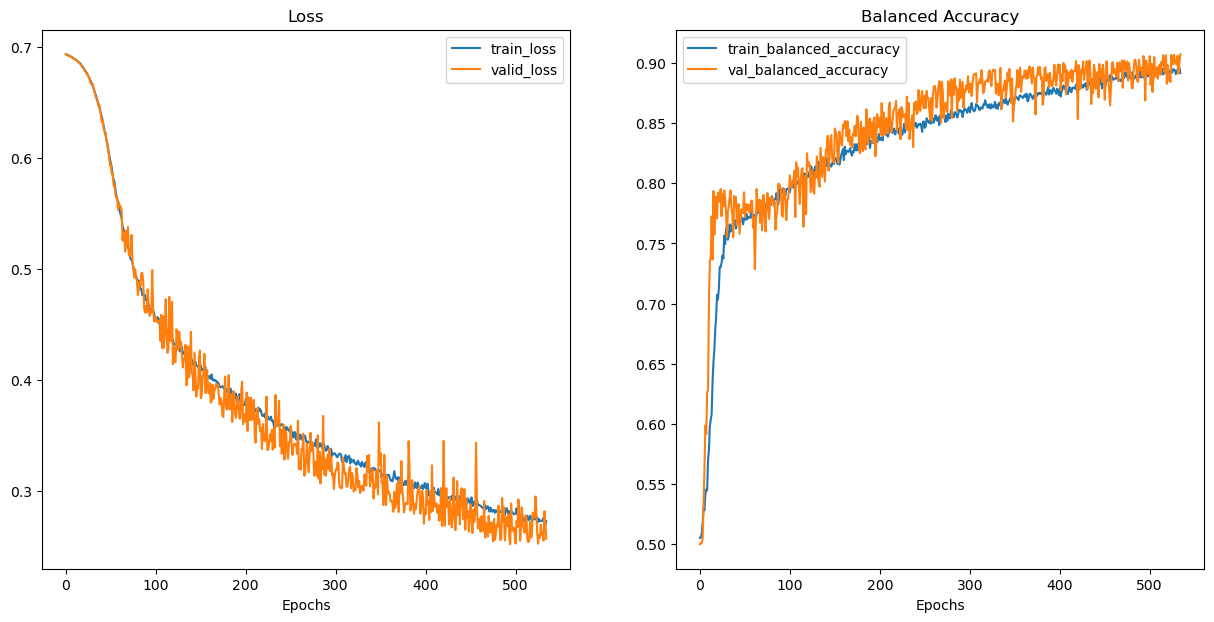

In [143]:
helper_functions.plot_loss_curves(results)
#plt.savefig(f'All_TFs_CNN1_ADAM_BCEWithLogits_KERNEL=10_seq=200b.png')

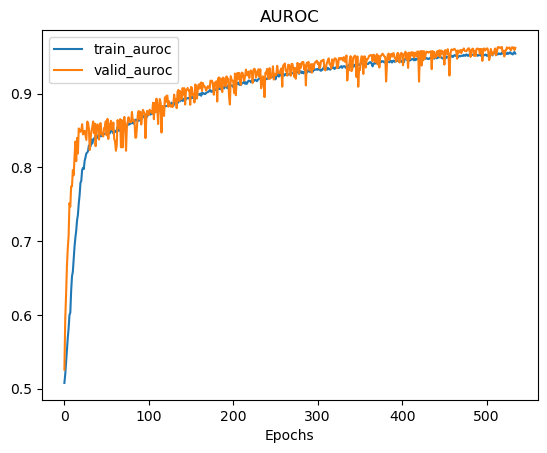

In [144]:
helper_functions.plot_auroc(results)

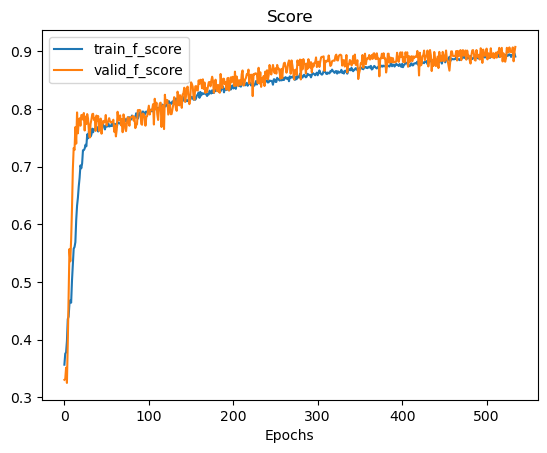

In [145]:
helper_functions.plot_f_score(results)

In [146]:
test_results = engine_boosted.test_step(model = model,
                                        dataloader = test_loader,
                                        loss_fn = loss_fn,
                                        device =device)

In [147]:
# Unpack the values
test_loss, test_bal_acc, test_mcc, test_f_score, test_auroc = test_results

print("Performance on held out test set")
print(f'Test loss: {float(test_loss)}  | Test bal acc {float(test_bal_acc)} |\
Test mcc {float(test_mcc)} | Test_f_score {float(test_f_score)} | Test auroc {float(test_auroc)}')   
    

Performance on held out test set
Test loss: 0.31245987862348557  | Test bal acc 0.8695227458791269 |Test mcc 0.739661665546376 | Test_f_score 0.8701805227577982 | Test auroc 0.9395498633384705


In [148]:

def test_step2(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float, float, float, float, int, Tuple[int, int, int, int]]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss, testing metrics, total length of the DataLoader, and confusion matrix values.
    In the form (test_loss, test_bal_acc, test_mcc, test_f_score, test_auroc, total_length, confusion_matrix_values).
    For example:

    (0.0223, 0.8985, 0.85, 0.9, 0.95, 1000, (100, 50, 20, 830))
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test metric values
    test_loss, test_bal_acc, test_mcc, test_f_score, test_auroc = 0, 0, 0, 0, 0

    # Track true positives, true negatives, false positives, false negatives
    all_true_labels = []
    all_pred_labels = []

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y_one_hot, y) in enumerate(dataloader):
            # Send data to target device
            X, y_one_hot, y = X.to(device), y_one_hot.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y_one_hot)
            test_loss += loss.item()

            # Calculate and accumulate metrics
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
            test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
            test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
            test_auroc += multiclass_auroc(test_pred_logits, y.squeeze(), num_classes=2)

            # Track true labels and predicted labels
            all_true_labels.extend(y.cpu().numpy())
            all_pred_labels.extend(test_pred_labels.cpu().numpy())

    # Calculate confusion matrix
    confusion_matrix_values = confusion_matrix(all_true_labels, all_pred_labels).ravel()

    # Adjust metrics to get average loss and metrics per batch
    total_length = len(dataloader.dataset)
    test_loss = test_loss / len(dataloader)
    test_bal_acc = test_bal_acc / len(dataloader)
    test_mcc = test_mcc / len(dataloader)
    test_f_score = test_f_score / len(dataloader)
    test_auroc = test_auroc / len(dataloader)

    return test_loss, test_bal_acc, test_mcc, test_f_score, test_auroc, total_length, confusion_matrix_values

In [149]:
from typing import List

def calculate_metrics_at_thresholds(model, dataloader, loss_fn, device, thresholds: List[float]):
    # Put model in eval mode
    model.eval()

    # Placeholder for results at different thresholds
    results_at_thresholds = []

    for threshold in thresholds:
        # Setup test loss and test metric values for the current threshold
        test_loss, test_bal_acc, test_mcc, test_f_score, test_auroc = 0, 0, 0, 0, 0

        # Track true positives, true negatives, false positives, false negatives
        all_true_labels = []
        all_pred_labels = []

        # Turn on inference context manager
        with torch.inference_mode():
            # Loop through DataLoader batches
            for batch, (X, y_one_hot, y) in enumerate(dataloader):
                # Send data to target device
                X, y_one_hot, y = X.to(device), y_one_hot.to(device), y.to(device)

                # 1. Forward pass
                test_pred_logits = model(X)

                # 2. Apply threshold to predicted probabilities
                test_pred_probs = torch.sigmoid(test_pred_logits)
                test_pred_labels = (test_pred_probs > threshold).float()
                test_pred_labels = np.argmax(test_pred_labels, axis=1)

                # 3. Calculate and accumulate loss
                loss = loss_fn(test_pred_logits, y_one_hot)
                test_loss += loss.item()

                # Calculate and accumulate metrics
                test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(),)
                test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
                test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
                test_auroc += multiclass_auroc(test_pred_logits, y.squeeze(), num_classes=2)

                # Track true labels and predicted labels
                all_true_labels.extend(y.cpu().numpy())
                all_pred_labels.extend(test_pred_labels.cpu().numpy())

        # Calculate confusion matrix
        confusion_matrix_values = confusion_matrix(all_true_labels, all_pred_labels).ravel()

        # Adjust metrics to get average loss and metrics per batch
        total_length = len(dataloader.dataset)
        test_loss = test_loss / len(dataloader)
        test_bal_acc = test_bal_acc / len(dataloader)
        test_mcc = test_mcc / len(dataloader)
        test_f_score = test_f_score / len(dataloader)
        test_auroc = test_auroc / len(dataloader)

        results_at_thresholds.append((test_loss, test_bal_acc , test_mcc, test_f_score, test_auroc, total_length, confusion_matrix_values))

    return results_at_thresholds




In [150]:
# Example usage
thresholds_to_test = [0.3, 0.4, 0.5, 0.6]
results = calculate_metrics_at_thresholds(model, test_loader, loss_fn, device, thresholds_to_test)

# Print or use the results as needed
for threshold, result in zip(thresholds_to_test, results):
    print(f"Threshold {threshold}: {result}\n")

Threshold 0.3: (0.3180837631225586, 0.8606859003470984, 0.7269630076682748, 0.8583170624928974, tensor(0.9386), 1454, array([676,  51, 155, 572]))

Threshold 0.4: (0.3240569084882736, 0.8683918058646306, 0.7383575895662354, 0.8683634428228976, tensor(0.9353), 1454, array([656,  71, 115, 612]))

Threshold 0.5: (0.32183544089396793, 0.8669295220414135, 0.73500070965063, 0.8667904198134265, tensor(0.9360), 1454, array([626, 101,  91, 636]))

Threshold 0.6: (0.32035624360044795, 0.8673150995915578, 0.7360870656238133, 0.8664115948290615, tensor(0.9368), 1454, array([655,  72, 117, 610]))



# Make loader with metadata to check results in each region

In [151]:
df_test

NameError: name 'df_test' is not defined

In [ ]:
 make_loader_meta(X_test: torch.tensor,
                 y_test: torch.tensor,
                 metadata_df: pd.DataFrame,

